In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import gsw

In [2]:
def State(case_id):

    file0 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase/state_' + str(format(case_id,'03d')) + '.nc')

    t0 = 90
    tn = 121
    # removed duplicated data caused by model restart
    file = file0.isel(T=~file0.get_index("T").duplicated())
    state = file.isel(X=range(260), Xp1=range(261), Y=range(35,45), Yp1=range(35,45), T=range(t0,tn))
    
    X = state.X.data 
    x_dist = X / 1000
    depth = state.Z.data
    pres = gsw.p_from_z(depth, 55)
    pt = state.Temp.data.mean(axis=(0,2)) # Y-axis average
    s = state.S.data.mean(axis=(0,2))
    p = np.tile(pres,[len(X),1]).T
    rho = gsw.rho(s, pt, p)
    
    # Along-fjord velocity
    u0 = state.U.data # dims = T, Z, Y, Xp1
    u_ymean = (u0[:, :, :, 1:].mean(2) + u0[:, :, :, :-1].mean(2)) / 2
    u = u_ymean.mean(0) # dims = Z, X
    
    # Vetical velocity
    W0 = state.W.data
    bt = np.zeros((W0.shape[0],1,W0.shape[2],W0.shape[3])) # Add vertical velocity (0 m/s) at the bottom
    W = np.concatenate((W0, bt), axis=1)
    wzy = (W[:,1:,:,:] + W[:,:-1,:,:]) / 2
    w = wzy.mean(axis=(0,2))
    
    pt0 = file.Temp.data.mean(2)[1,:,:260]
    mask = (pt0 == 0)
    pt[mask] = np.nan
    s[mask] = np.nan
    rho[mask] = np.nan
    u[mask] = np.nan
    w[mask] = np.nan
    
## calculate upper layer thickness    
#     h1 = np.empty(len(X)-2)
#     z_th = np.empty(len(X)-2)
#     for i in range(1,len(X)-1):
#         l = np.where(u[:, i] < 0)[-1][0] - 1
        
#         if l <= 19:
#             h1[i-1] = -depth[l]+1
#         elif l <= 49:
#             h1[i-1] = -depth[l]+2
#         elif l <= 89:
#             h1[i-1] = -depth[l]+3
     
#     for j in range(len(h1)-1):
#         if np.abs(h1[j+1]-h1[j]) > 30:
#             h1[j+1] = h1[j]
        
    return (x_dist, depth, pt, rho, u, w)

In [ ]:
def IFA(Hs):
    # Grid areas
#     Area = np.empty([50, 9])
#     Area[:10,:] = 100
#     Area[10:20,:] = 200
#     Area[20:30,:] = 300
#     Area[30:40,:] = 800
#     Area[40:,:] = 1600
#     file = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/Qsg500/icefrntA_' + str(format(Hs,'03d')) + '.nc')
#     t0 = 89
#     tn = len(file.T)
#     state = file.isel(Y=range(30,39), T=range(t0,tn))
    
    Area = np.empty([90, 10])
    Area[:20,:] = 400
    Area[20:50,:] = 800
    Area[50:,:] = 1200

    file0 = xr.open_dataset('/work/oceans/wbao/MITgcm_results/iceplume/1_BaseCase/icefrntA_' + str(format(Hs,'03d')) + '.nc')
    t0 = 89
    tn = 120
    # removed duplicated data caused by model restart
    file = file0.isel(T=~file0.get_index("T").duplicated())
    state = file.isel(Y=range(35,45), T=range(t0,tn))
    
    MR = state.icefrntA.isel(X=1).data.mean(0) # Melt rate at the icefront
    Qsm = (MR*Area).sum()/(24*3600)
    return Qsm

In [3]:
CaseNum = np.array([1, 2, 3, 4, 5, 6])
    
x1, z1, pt1, rho1, u1, w1 = State(CaseNum[-1]) # No sill case
x2, z2, pt2, rho2, u2, w2 = State(CaseNum[-2]) # hs/h = 0.12
x3, z3, pt3, rho3, u3, w3 = State(CaseNum[0]) # hs/h = 0.04

In [ ]:
z3[22]

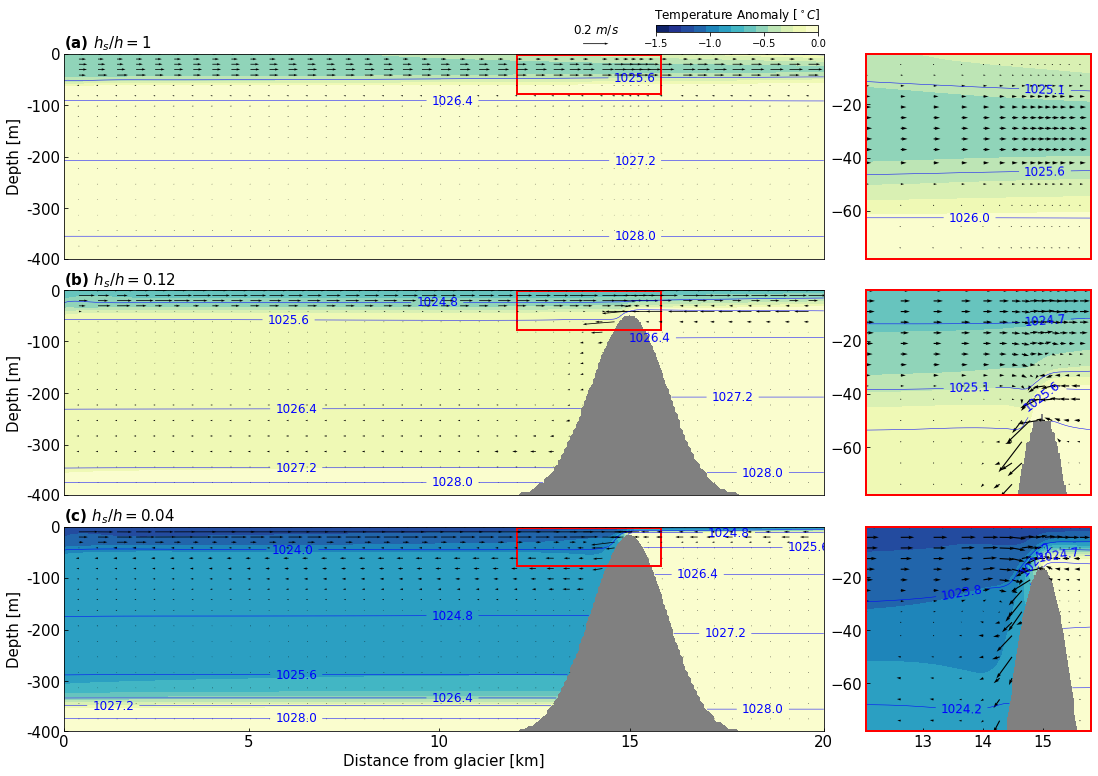

In [4]:

gridsize = (3, 4)
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=3)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=3)
ax3 = plt.subplot2grid(gridsize, (2, 0), colspan=3)
ax4 = plt.subplot2grid(gridsize, (0, 3), colspan=1, rowspan=1)
ax5 = plt.subplot2grid(gridsize, (1, 3), colspan=1, rowspan=1)
ax6 = plt.subplot2grid(gridsize, (2, 3), colspan=1, rowspan=1)
fig.tight_layout()

ct = np.linspace(-1.5,0,14) # Contour range for temperature
crho = np.linspace(1020,1028,11) # Contour range for density
cmap = 'YlGnBu_r'


T0 = 10; # initial fjord temperature
zid = 40; # depth index
sl, sr = 140, 220 # quiver over sill range
# Zoom plot range
l, r = 120, 210
top, bot = 0, 30
x1z = x1[l:r]
z1z = z1[top:bot]
u1z = u1[top:bot,l:r]
w1z = w1[top:bot,l:r]
x2z = x2[l:r]
z2z = z2[top:bot]
u2z = u2[top:bot,l:r]
w2z = w2[top:bot,l:r]
x3z = x3[l:r]
z3z = z3[top:bot]
u3z = u3[top:bot,l:r]
w3z = w3[top:bot,l:r]

im1 = ax1.contourf(x1,z1,pt1-T0, ct, cmap=cmap)
#current_cmap = matplotlib.cm.get_cmap()
#cmap.set_bad('red',1.)
ax1.xaxis.set_visible(False)
#ax1.annotate(text='', xy=(0.745,0.84), xycoords='axes fraction', xytext=(0.745,1), textcoords='axes fraction',arrowprops={'arrowstyle': '<|-|>','color':'red','linewidth':4,'alpha':0.6})
ax1.set_xlim([x1[1],x1[-1]])
ax1.set_facecolor('grey')


cbaxes = fig.add_axes([0.58, 1.01, 0.15, 0.01])
cbar = fig.colorbar(im1,cax=cbaxes, orientation='horizontal')
cbar.set_ticks([-1.5,-1,-0.5,0])
cbar.ax.set_title('Temperature Anomaly [$^\circ C$]', size=12)

# Plot isopycnals
CS1 = ax1.contour(x1,z1,rho1,crho, colors='b', linewidths=.5)
plt.clabel(CS1, fmt='%1.1f', fontsize=12, inline=1)
#ax1.plot(x1[1:-1],-h1, '--w', lw=2)
ax1.set_ylabel('Depth [m]', size=15)
ax1.set_yticks([z1[0], -100, -200, -300, z1[-1]])
ax1.set_yticklabels(["0","-100","-200","-300","-400"])
ax1.tick_params(direction='in', labelsize=15)
ax1.set_title('(a) $h_s/h=1$', loc='left', size=15, weight='bold')




im2 = ax2.contourf(x2,z2,pt2-T0, ct, cmap=cmap)
ax2.xaxis.set_visible(False)
#ax2.annotate(text='', xy=(0.745,0.72), xycoords='axes fraction', xytext=(0.745,1), textcoords='axes fraction', arrowprops={'arrowstyle': '<|-|>','color':'red','linewidth':4,'alpha':0.6})
CS2 = ax2.contour(x2,z2,rho2, crho, colors='b', linewidths=.5)
plt.clabel(CS2, fmt='%1.1f', fontsize=12, inline=1)

# Plot velocity


#ax2.plot(x2[1:-1],-h2, '--w', lw=2)
ax2.set_ylabel('Depth [m]', size=15)
ax2.set_yticks([z2[0], -100, -200, -300, z2[-1]])
ax2.set_yticklabels(["0","-100","-200","-300","-400"], size=15)
ax2.tick_params(direction='in', labelsize=15)
ax2.set_title('(b) $h_s/h=0.12$', loc='left', size=15, weight='bold')
ax2.set_xlim([x2[1],x2[-1]])
ax2.set_facecolor('grey')




im3 = ax3.contourf(x3,z3,pt3-T0, ct, cmap=cmap)
#ax3.xaxis.set_visible(False)
#ax3.annotate(text='', xy=(0.745,0.58), xycoords='axes fraction', xytext=(0.745,1), textcoords='axes fraction', arrowprops={'arrowstyle': '<|-|>','color':'red','linewidth':4,'alpha':0.6})
CS3 = ax3.contour(x3,z3,rho3, crho, colors='b', linewidths=.5)
plt.clabel(CS3, fmt='%1.1f', fontsize=12, inline=1)
#ax3.plot(x3[1:-1],-h3, '--w', lw=2)





ax3.set_ylabel('Depth [m]', size=15)
ax3.set_yticks([z3[0], -100, -200, -300, z3[-1]])
ax3.set_yticklabels(["0","-100","-200","-300","-400"])
ax3.tick_params(direction='in', labelsize=15)
ax3.set_title('(c) $h_s/h=0.04$', loc='left', size=15, weight='bold')
ax3.set_xlim([x3[1],x3[-1]])
ax3.set_facecolor('grey')
ax3.set_xticks([x3[1], 5, 10, 15, x3[-1]])
ax3.set_xticklabels(["0","5","10","15","20"])
ax3.set_xlabel('Distance from glacier [km]', size=15)




im4 = ax4.contourf(x1z,z1z,pt1[top:bot,l:r]-T0, ct, cmap=cmap)
ax4.xaxis.set_visible(False)
CS4 = ax4.contour(x1z,z1z,rho1[top:bot,l:r], np.linspace(1022,1026,10), colors='b', linewidths=.5)
plt.clabel(CS4, fmt='%1.1f', fontsize=12, inline=1)




ax4.tick_params(direction='in', labelsize=15)
ax4.set_xlim([x1[l],x1[r-1]])
ax4.set_facecolor('grey')
for side in ax4.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax4.spines[side].set_linewidth(2)
    ax4.spines[side].set_color('red')

im5 = ax5.contourf(x2z,z2z,pt2[top:bot,l:r]-T0, ct, cmap=cmap)
ax5.xaxis.set_visible(False)
CS5 = ax5.contour(x2z,z2z,rho2[top:bot,l:r], np.linspace(1022,1026,10), colors='b', linewidths=.5)
plt.clabel(CS5, fmt='%1.1f', fontsize=12, inline=1)



ax5.tick_params(direction='in', labelsize=15)
ax5.set_xlim([x2[l],x2[r-1]])
ax5.set_facecolor('grey')
for side in ax5.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax5.spines[side].set_linewidth(2)
    ax5.spines[side].set_color('red')

im6 = ax6.contourf(x3z,z3z,pt3[top:bot,l:r]-T0, ct, cmap=cmap)
CS6 = ax6.contour(x3z,z3z,rho3[top:bot,l:r], np.linspace(1022,1026,10), colors='b', linewidths=.5)
plt.clabel(CS6, fmt='%1.1f', fontsize=12, inline=1)


ax6.tick_params(direction='in', labelsize=15)
ax6.set_xlim([x3[l],x3[r-1]])
ax6.set_facecolor('grey')
#ax6.set_xlabel('[km]', size=15)
for side in ax6.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax6.spines[side].set_linewidth(2)
    ax6.spines[side].set_color('red')

# Add zoom box
from matplotlib.patches import Rectangle
rect1 = Rectangle((x1z[0],z1z[-1]),x1z[-1]-x1z[0],z1z[1]-z1z[-1],linewidth=2,edgecolor='r',facecolor='none')
rect2 = Rectangle((x2z[0],z2z[-1]),x2z[-1]-x2z[0],z2z[1]-z2z[-1],linewidth=2,edgecolor='r',facecolor='none')
rect3 = Rectangle((x3z[0],z3z[-1]),x3z[-1]-x3z[0],z3z[1]-z3z[-1],linewidth=2,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax1.add_patch(rect1)
ax2.add_patch(rect2)
ax3.add_patch(rect3)

# Plot velocity
n1 = 6
Q_4 = ax4.quiver(x1z[::n1],z1z[::2],u1z[::2,::n1], w1z[::2,::n1]*15,scale=3, width=0.005, color='k')
Q_5 = ax5.quiver(x2z[::n1],z2z[::2],u2z[::2,::n1], w2z[::2,::n1]*15,scale=3, width=0.005, color='k')
Q_6 = ax6.quiver(x3z[::n1],z3z[::2],u3z[::2,::n1], w3z[::2,::n1]*15,scale=3, width=0.005, color='k')



u1_sill = u1[:,sl:sr]
w1_sill = w1[:,sl:sr]
x1_sill = x1[sl:sr]
n2 = 5
Q_1s = ax1.quiver(x1_sill[::10],z1[::n2],u1_sill[::n2,::10], w1_sill[::n2,::10],scale=6, width=0.001, color='k')
u1[:,sl:sr] = 'nan'
w1[:,sl:sr] = 'nan'
Q_1 = ax1.quiver(x1[::n2],z1[::n2],u1[::n2,::n2], w1[::n2,::n2],scale=6, width=0.001, color='k')
ax1.quiverkey(Q_1, 0.7, 1.05, 0.2, r'0.2 $m/s$', fontproperties={'size':12}, coordinates='axes')


u2_sill = u2[:,sl:sr]
w2_sill = w2[:,sl:sr]
x2_sill = x2[sl:sr]
Q_2s = ax2.quiver(x2_sill[::10],z2[::n2],u2_sill[::n2,::10], w2_sill[::n2,::10],scale=6, width=0.001, color='k')
u2[:,sl:sr] = 'nan'
w2[:,sl:sr] = 'nan'
Q_2 = ax2.quiver(x2[::n2],z2[::n2],u2[::n2,::n2], w2[::n2,::n2],scale=6, width=0.001, color='k')


u3_sill = u3[:,sl:sr]
w3_sill = w3[:,sl:sr]
x3_sill = x3[sl:sr]
Q_3s = ax3.quiver(x3_sill[::10],z3[::n2],u3_sill[::n2,::10], w3_sill[::n2,::10],scale=6, width=0.001, color='k')

u3[:,sl:sr] = 'nan'
w3[:,sl:sr] = 'nan'
Q_3 = ax3.quiver(x3[::n2],z3[::n2],u3[::n2,::n2], w3[::n2,::n2],scale=n2, width=0.001, color='k')

In [ ]:
u1z, w1z

In [5]:
fig_path ="/home/1959/Jupyter_Figs/FjordModeling/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(fig_path + '/1-BaseCase.png', dpi=200, bbox_inches='tight') 